In [4]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [2]:
import torch.nn as nn
from torch import Tensor, LongTensor
from torch.nn.functional import logsigmoid


def BPRLoss(gap):
    return -logsigmoid(gap)
    

class BPR(nn.Module):
    def __init__(self, n_user, n_item
                 , k_dim, std_user, std_item):
        from torch import sigmoid

        super(BPR, self).__init__()
        # embeddings
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.normal_(self.embedding_user.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)

    def forward(self, user, pos_item, neg_item):
        pos_score = (self.embedding_user(user) 
                     * self.embedding_item(pos_item)).sum(1)
        neg_score = (self.embedding_user(user) 
                     * self.embedding_item(neg_item)).sum(1)
        return pos_score-neg_score

    def pred_all(self, ):
        return self.embedding_user.weight \
               @ self.embedding_item.weight.T

In [3]:
def naive_pairwise_loader(rat_dict, items, batch_size, neg_size=None
                    , random_sampling=True, user_size=None, pos_size=None
                    , user_neg_dict=None):
    
    from random import choices
    from torch.utils.data import DataLoader


    if not isinstance(items, set):
        all_items = set(items)
    all_items = items
    
    train_data = []

    if not random_sampling: # goover all dataset
        for user in rat_dict:
            pos_items = list(rat_dict[user].keys())
            neg_candidates = list(all_items - set(pos_items)) if user_neg_dict is None \
                             else user_neg_dict[user]
            neg_items = choices(neg_candidates, k=len(pos_items)*neg_size)
            u = [user]*len(pos_items)*neg_size
            pos_items *= neg_size
            train_data.extend(zip(u, pos_items, neg_items))           
                
    else:
        users = choices(list(rat_dict.keys()), k=user_size)
        for user in users:
            neg_candidates = list(all_items - set(rat_dict[user])) if user_neg_dict is None \
                             else user_neg_dict[user]
            pos_items = choices(list(rat_dict[user].keys()), k=pos_size)
            neg_items = choices(neg_candidates, k=pos_size*neg_size)

            # duplicate
            u = [user] * pos_size*neg_size
            pos_items *= neg_size
            train_data.extend(zip(u, pos_items, neg_items))
        
    return DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)


# things for sampling
items = list(range(n_item))
# first define the dictionary can accelerate sampling efficiency
user_neg_dict = {
    u:list(set(items)-set(ratings_train_dict[u].keys()))
     for u in ratings_train_dict
}

# DL1: roll over all data
dl_roll = naive_pairwise_loader(
    rat_dict=ratings_train_dict, items=items, user_neg_dict=user_neg_dict
    , random_sampling=False, neg_size=4
    , batch_size=128
)
# DL2: sampling by parameters
dl_sample = naive_pairwise_loader(
    rat_dict=ratings_train_dict, items=items, user_neg_dict=user_neg_dict
    , random_sampling=True, neg_size=4
    , user_size=256, pos_size=64
    , batch_size=128
)

In [5]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np


def train_model(model, opt, rat_train, n_items
                , use_random_sampling, neg_size
                , user_size, pos_size
                , use_cuda, n_epochs, batch_size
                , report_interval):

    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
    else:
        compute_device = device('cpu')

    # things for sampling
    items = list(range(n_item))
    # first define the dictionary can accelerate sampling efficiency
    user_neg_dict = {
        u:list(set(items)-set(rat_train[u].keys()))
        for u in rat_train}

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = dl_sample = naive_pairwise_loader(
                        rat_dict=rat_train, items=items
                        , user_neg_dict=user_neg_dict
                        , random_sampling=use_random_sampling
                        , neg_size=neg_size
                        , user_size=user_size, pos_size=pos_size
                        , batch_size=batch_size
                    )

        ep_loss = []
        for i, batch in enumerate(train_data):
            user, pos_item, neg_item = batch

            model.zero_grad()

            user = autograd.Variable(LongTensor(user)).to(compute_device)
            pos_item = autograd.Variable(LongTensor(pos_item)).to(compute_device)
            neg_item = autograd.Variable(LongTensor(neg_item)).to(compute_device)

            preds = model(user, pos_item, neg_item)
            loss = BPRLoss(gap=preds) # todo

            loss.sum().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())
            
        train_loss_by_ep.append(np.mean(ep_loss))

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep


# from recom.model.pairwise import BPR
from torch import optim
import warnings
warnings.filterwarnings("ignore")

K_DIM=16
STD_USER=1
STD_ITEM=1
NEG_SIZE=4
USER_SIZE=256
POS_SIZE=128
USE_CUDA=False
N_EPOCHES=36
BATCH_SIZE=2048
INTERVAL=8

bpr = BPR(
    n_user=n_user, n_item=n_item
    , k_dim=K_DIM
    , std_user=STD_USER
    , std_item=STD_ITEM
)
opt = optim.SGD(bpr.parameters(), lr=0.001, weight_decay=0.01, momentum=0.01)
model, train_loss_by_ep, test_rmse_by_ep = train_model(
    model=bpr, opt=opt, rat_train=ratings_train_dict
    , n_items=n_item, use_random_sampling=True
    , neg_size=NEG_SIZE
    , user_size=USER_SIZE, pos_size=POS_SIZE
    , use_cuda=USE_CUDA, n_epochs=N_EPOCHES, batch_size=BATCH_SIZE
    , report_interval=INTERVAL
)

Epoch: 8, Time: 5.55,  /Average train loss 1.80155
			/Average test loss 0.0
Epoch: 16, Time: 4.78,  /Average train loss 1.29066
			/Average test loss 0.0
Epoch: 24, Time: 4.49,  /Average train loss 0.94909
			/Average test loss 0.0
Epoch: 32, Time: 4.5,  /Average train loss 0.73036
			/Average test loss 0.0


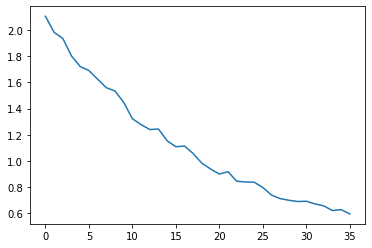

In [9]:
import matplotlib.pyplot as plt


plt.plot(list(range(len(train_loss_by_ep))), train_loss_by_ep)